In [38]:
import numpy as np
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [28]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [29]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [30]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService
from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType

In [31]:
DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["XRPUSDT"]
SLEEP_INTERVAL = 1
DOM = 10

datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

In [66]:
def plot_order_book(bids, asks, highlight_best=True):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])
    
    bids_df = bids_df.sort_values(by='price', ascending=False)
    
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    clear_output(wait=True)

    sns.set_style("whitegrid")
    
    plt.figure(figsize=(10, 6))
    
    plt.figure(figsize=(12, 8))

    sns.lineplot(x=bids_df['price'], y=bids_df['cum_quantity'], label='Bids', color='green', linewidth=2)
    sns.lineplot(x=asks_df['price'], y=asks_df['cum_quantity'], label='Asks', color='red', linewidth=2)

    plt.fill_between(bids_df['price'], bids_df['cum_quantity'], color='green', alpha=0.3, step='mid')
    plt.fill_between(asks_df['price'], asks_df['cum_quantity'], color='red', alpha=0.3, step='mid')

    if highlight_best:
        best_bid = bids_df['price'].iloc[0]
        best_ask = asks_df['price'].iloc[0]
        
        plt.axvline(best_bid, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
        plt.axvline(best_ask, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)
        
        mid_price = (best_bid + best_ask) / 2
        plt.axvline(mid_price, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)

    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Cumulative Quantity', fontsize=12)
    plt.title('Order Book Depth Chart', fontsize=14)

    plt.legend()
    
    plt.show()

<Figure size 1000x600 with 0 Axes>

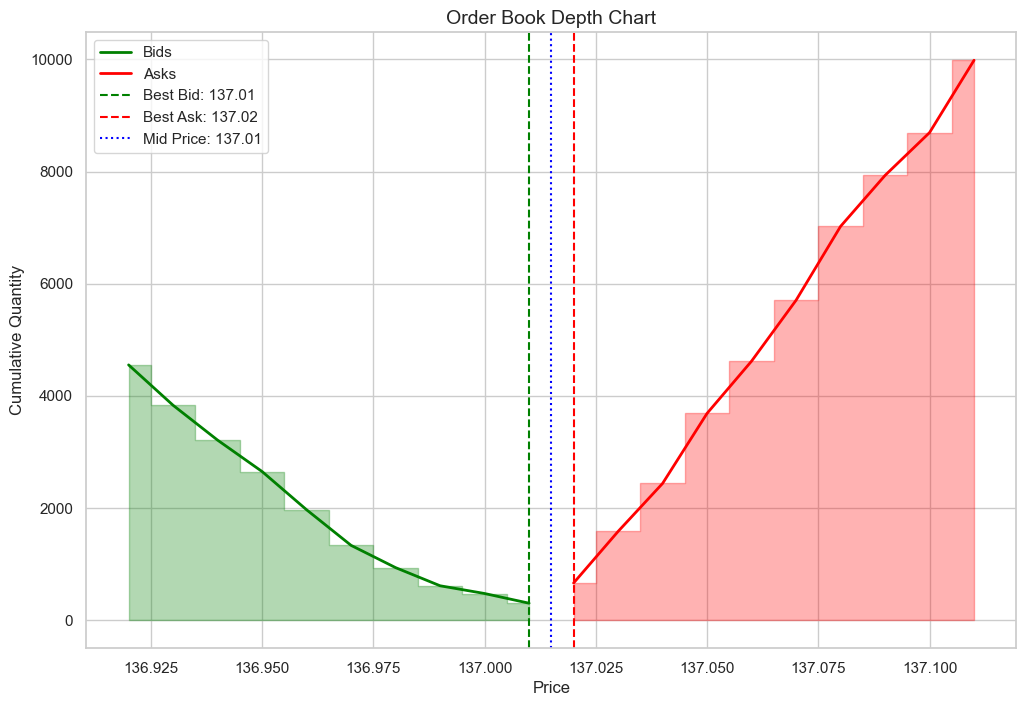

KeyboardInterrupt: 

In [67]:
ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

symbols = ds.fetch_future_symbols()
symbol = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)
    
    plot_order_book(np.array(bids), np.array(asks))
    
    time.sleep(SLEEP_INTERVAL)